In [2]:
!mkdir simRes

mkdir: cannot create directory ‘simRes’: File exists


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pdb
import copy
import random
import sys
import sys

In [ ]:


def boltzmann_explr_opin(qList, incomingNodeIndex, gList, tempVal, seedIn):

    np.random.seed(seedIn)
    if incomingNodeIndex != []:
        qList[incomingNodeIndex] = 0
    maxQ = max(qList)
    maxQTmp = maxQ/tempVal
    MAXQTMPALLOWED = 500
    MAXQALLOWED = MAXQTMPALLOWED*tempVal
    if maxQTmp>MAXQTMPALLOWED:
        subtractQ = maxQ-MAXQALLOWED
        qListNew = [xx-subtractQ for xx in qList]
        print("Q", end=' ')
    elif maxQ<0:
        qListNew = [xx-((maxQ)*tempVal) for xx in qList]
        pdb.set_trace()
    else:
        qListNew = qList

    expQList = [np.exp(x/tempVal) for x in qListNew]
    pDenom = float(sum(expQList))

    #if pDenom == 0: # often encountered in local cooperation case with exp(.) scaling factor
    #    pDenom = 1 # helps in case of local cooperation with exp(.) scaling factor
    #    for ii in range(len(expQList)):
    #        expQList[ii] = 1.0/len(expQList)

    pList = [float(x)/pDenom for x in expQList]

    rndIdx = np.random.choice(len(pList),1,p=pList)

    actionIdx = rndIdx[0]
    action = gList[actionIdx]
     
    return [action, actionIdx]

def compute_prob(vecIn1, vecIn2, t, eta, xi):

    # find minimum tau
    vecIn1Delta = np.add(vecIn1, -t) # vecIn1Delta is negative number

    minVecIn2 = np.min(vecIn2)
    
    #noTxTmp = (np.random.rand(1,1)>np.exp(-10*(minVecIn2))) # for debug
    #noTxTmp = (np.random.rand(1,1)>np.exp(0*(minVecIn2))) # for debug # this with vecInNeg2 factor = -3 works with pa graph
    #noTxTmp = (np.random.rand(1,1)>np.exp(-1*(minVecIn2))) # for debug # this with vecInNeg2 factor = -1 works with pa graph for batchsize of 20
    noTxTmp = (np.random.rand(1,1)>np.exp(-eta*(minVecIn2))) 
    noTx = noTxTmp[0][0]

    #noTx = False # for debug # works best
    
    if noTx == False:
        
        #vecInNeg1 = np.multiply(vecIn1Delta, 1) # works best
        #vecInNeg2 = np.multiply(vecIn2, 0.) # works best
        
        vecInNeg1 = np.multiply(vecIn1Delta, xi) 
        vecInNeg2 = np.multiply(vecIn2, eta) 
        
        vecInNeg = np.add(vecInNeg1, vecInNeg2)
        vecNegExp = np.exp(vecInNeg)
        probVec = normalize_vector(vecNegExp)
    else:
        probVec = []

    ##if noTx == False and minVecIn2>0 and len(vecIn1)>1:
    #if noTx == False and len(vecIn1)>1:
    #    print(sorted(vecIn1Delta, reverse=True))

    #if len(vecIn1)>1:
    #    pdb.set_trace()

    return [probVec, noTx]

def gen_graph(Params):
    # 2D grid graph
    if Params['graphName'] == 'grid2d':
        #g = nx.grid_2d_graph(Params['numNodesRow'], Params['numNodesCol'])
        g = nx.grid_graph(dim=[Params['numNodesRow'], Params['numNodesCol']])
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        gnodes = [xx for xx in g.nodes()]

        for ind in range(g.number_of_nodes()):
            nodeRow = gnodes[ind][0]
            nodeCol = gnodes[ind][1]
            nodeIndex = nodeRow*Params['numNodesRow']+nodeCol
            neighborList = [xx for xx in nx.neighbors(g, gnodes[ind])]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn][0]*Params['numNodesRow']+neighborList[indnn][1])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[nodeIndex] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[nodeIndex] = len(nnList)
            del nnList[:]

    # 3D grid graph
    elif Params['graphName'] == 'grid3d':
        g = nx.grid_graph(dim=[Params['numNodesDim1'], Params['numNodesDim2'], Params['numNodesDim3']])
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        gnodes = [xx for xx in g.nodes()]
        for ind in range(g.number_of_nodes()):
            nodeDim1 = gnodes[ind][0]
            nodeDim2 = gnodes[ind][1]
            nodeDim3 = gnodes[ind][2]
            nodeIndex = nodeDim1*Params['numNodesDim2']*Params['numNodesDim3']+nodeDim2*Params['numNodesDim3']+nodeDim3
            neighborList = nx.neighbors(g, gnodes[ind])
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn][0]*Params['numNodesDim2']*Params['numNodesDim3']+neighborList[indnn][1]*Params['numNodesDim3']+neighborList[indnn][2])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[nodeIndex] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[nodeIndex] = len(nnList)
            del nnList[:]

    # Random Geometric Graph
    elif Params['graphName'] == 'rgg':
        g = nx.random_geometric_graph(Params['numNodes'], radius = Params['rggRad'], seed=0)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            #neighborList = nx.neighbors(g, g.nodes()[ind])
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

#        for ind in range(Params['numNodes']):
#            print(gn[ind])

    # Power-law tree graph
    elif Params['graphName'] == 'pltree':
        g = nx.random_powerlaw_tree(Params['numNodes'], gamma=Params['pltreegamma'], seed=None, tries = 10000)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

    # Preferential attachment graph
    elif Params['graphName'] == 'pa':
        g = nx.barabasi_albert_graph(n=Params['numNodes'], m=Params['mVal'], seed=None)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

    elif Params['graphName'] == 'er':
        pEr = (2*np.log(Params['numNodes']))/Params['numNodes']
        g = nx.gnp_random_graph(Params['numNodes'], p=pEr, seed=None, directed=False)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

    elif Params['graphName'] == 'wxrnd':
        g = nx.waxman_graph(Params['numNodes'], alpha=Params['alphaWxRnd'], beta=Params['betaWxRnd'], L=None, domain=(0,0,1,1))
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

    elif Params['graphName'] == 'plclust':
        g = nx.powerlaw_cluster_graph(Params['numNodes'], m=Params['mVal'],p=Params['pTriangle'], seed=None)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

    elif Params['graphName'] == 'dgm':
        g = nx.dorogovtsev_goltsev_mendes_graph(Params['depthParam'], create_using=None)
        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]

        # graph as neighbor list
        gn = {}
        nnList = []
        numNbrDict = {}
        for ind in range(g.number_of_nodes()):
            neighborListPrime = nx.neighbors(g, ind)
            neighborList = [x for x in neighborListPrime]
            for indnn in range(len(neighborList)):
                nnList.append(neighborList[indnn])

            # check which one is convenient
            #gn[nodeIndex] = np.array(nnList) # gn as dictionary of numpy arrays
            gn[ind] = copy.copy(nnList) # gn as dictionary of lists
            numNbrDict[ind] = len(nnList)
            del nnList[:]         

    return (gn, numNbrDict, g)


# [[Q or R message],[time of reception],[incoming node]]
def prune_feed(feedList, indNode, timeNow, tauMax):

    # find and remove all the old (stale) feeds 
    lenFeedList = len(feedList[indNode][0])
    for indFeed in range(0, lenFeedList):
        # check if old feed
        if (timeNow-feedList[indNode][1][lenFeedList-indFeed-1])>tauMax:
            # remove all the record of lenFeedList-indFeed
            del feedList[indNode][0][lenFeedList-indFeed-1]
            del feedList[indNode][1][lenFeedList-indFeed-1]
            del feedList[indNode][2][lenFeedList-indFeed-1]
            del feedList[indNode][3][lenFeedList-indFeed-1]

    return feedList

def normalize_vector(vecIn):
    sumVal = np.sum(vecIn)
    vecNormalized = np.divide(vecIn, sumVal)
    return vecNormalized


def visualize_graph(G, g, blfMat, pos, Params):

    srcQ = Params['srcQNode']
    srcR = Params['srcRNode']
    numNodes = Params['numNodes']
    graphName = Params['graphName']
    
    #G = nx.random_geometric_graph(200, 0.125)
    # position is stored as node attribute data for random_geometric_graph
   
    # find node near center (0.5,0.5)
    dmin = 1
    ncenter = 0
    for n in pos:
        x, y = pos[n]
        d = (x - 0.5)**2 + (y - 0.5)**2
        if d < dmin:
            ncenter = n
            dmin = d

    plt.figure(100, figsize=(8, 8))
    plt.gcf().clear()

    # q to 
    

    # edge thickness according to action-values
    #for indNode in range(numNodes)
        #for nbr in g[ind]
    if graphName == 'grid2d':
        pos = dict((n, n) for n in G.nodes())
        nx.draw_networkx_edges(G, pos, alpha=0.1)
    else: #graphName == 'rgg':
        nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.1)

    for indNode in range(numNodes):
        alphaVal = (blfMat[indNode][0]/(blfMat[indNode][0]+blfMat[indNode][1]))
        if graphName == 'grid2d':
            indNodeRow = int(indNode/Params['numNodesRow'])
            indNodeCol = np.mod(indNode, Params['numNodesRow'])
            indNode4Grid = (indNodeRow, indNodeCol)
            srcRRow = int(srcR/Params['numNodesRow'])
            srcRCol =  np.mod(srcR, Params['numNodesRow']) 
            srcR4Grid = (srcRRow, srcRCol)
            nx.draw_networkx_nodes(G,pos, nodelist=[indNode4Grid, srcR4Grid],node_color='r', node_size=100, alpha=0.8*alphaVal)
        else: #graphName == 'rgg':
            nx.draw_networkx_nodes(G,pos, nodelist=[indNode, srcR],node_color='r', node_size=100, alpha=0.8*alphaVal)

        if graphName == 'pa':
            plt.xlim(-0.015, 0.015)
            plt.ylim(-0.015, 0.015)
            plt.axis('off')   
        elif graphName == 'pa' and numNodes == 1000:
            plt.xlim(-0.035, 0.035)
            plt.ylim(-0.07, 0.07)
            plt.axis('off')   


        if graphName == 'rgg':
            plt.xlim(-0.05, 1.05)
            plt.ylim(-0.05, 1.05)
            plt.axis('off')       


    for indNode in range(numNodes):
        alphaVal = (blfMat[indNode][1]/(blfMat[indNode][0]+blfMat[indNode][1]))
        if graphName == 'grid2d':
            indNodeRow = int(indNode/Params['numNodesRow'])
            indNodeCol = np.mod(indNode, Params['numNodesRow'])
            indNode4Grid = (indNodeRow, indNodeCol)
            srcQRow = int(srcQ/Params['numNodesRow'])
            srcQCol =  np.mod(srcQ, Params['numNodesRow']) 
            srcQ4Grid = (srcQRow, srcQCol)
            nx.draw_networkx_nodes(G,pos, nodelist=[indNode4Grid, srcQ4Grid],node_color='b', node_size=100, alpha=0.8*alphaVal)
        else: #graphName == 'rgg':
            nx.draw_networkx_nodes(G,pos, nodelist=[indNode, srcQ],node_color='b', node_size=100, alpha=0.8*alphaVal)

        if graphName == 'rgg':
            plt.xlim(-0.05, 1.05)
            plt.ylim(-0.05, 1.05)
            plt.axis('off')

        if graphName == 'pa' and numNodes == 500:
            plt.xlim(-0.015, 0.015)
            plt.ylim(-0.015, 0.015)
            plt.axis('off')   
        elif graphName == 'pa' and numNodes == 1000:
            plt.xlim(-0.035, 0.035)
            plt.ylim(-0.07, 0.07)
            plt.axis('off')   

    if Params['qLrnEn'] == True:
        plt.title('With Q-learning')
    else:
        plt.title('Without Q-learning')

    plt.show(block=False)


def display_centralities(gnx, srcQ, srcR):

    
    cntraltyEigVec = nx.eigenvector_centrality(gnx, max_iter=100, tol=1e-06, nstart=None, weight='weight')
    maxCntraltyEigVec = max(cntraltyEigVec.values())
    minCntraltyEigVec = min(cntraltyEigVec.values())
    print('srcQNode = ' + str(srcQ) + ', Eigenvector Centrality = ' +  str(cntraltyEigVec[srcQ]))
    print('srcRNode = ' + str(srcR) + ', Eigenvector Centrality = ' + str(cntraltyEigVec[srcR]))
    print('Max = ' + str(maxCntraltyEigVec) + ', Min = ' + str(minCntraltyEigVec))

    #print(" ")
    #
    #cntraltyBtw = nx.betweenness_centrality(gnx, k=None, normalized=True, weight=None, endpoints=False, seed=None)
    #maxCntraltyBtw = max(cntraltyBtw.values())
    #minCntraltyBtw = min(cntraltyBtw.values())
    #print('srcQNode = ' + str(srcQ) + ', Betweenness Centrality = ' +  str(cntraltyBtw[srcQ]))
    #print('srcRNode = ' + str(srcR) + ', Betweenness Centrality = ' + str(cntraltyBtw[srcR]))
    #print('Max = ' + str(maxCntraltyBtw) + ', Min = ' + str(minCntraltyBtw))

    return [cntraltyEigVec]

def save_results_qopin(sim, Params, dumpVarNames, dumpVarVals):

    ## save results
    savePath = sim['savePath']
    saveFileNameHead = sim['saveFileNameHead']
    graphName = Params['graphName']

    if graphName =='rgg': # [TODO]
        fileName = savePath+"/"+saveFileNameHead+"nodes"+str(Params['numNodes']) \
                +"slt"+str(Params['numPts'])+ "lrnRate"+ \
                str(Params['learnRate']) + "gam" + str(Params['gammaVal']) \
                + "temp" + str(Params['tempVal']) \
                + "blfBchSz"+str(Params['blfBatchSize'])\
                +"grph"+graphName+"rggRad"+str(Params['rggRad']) \
                + "eta"+str(Params['eta']+"xi"+Params['xi']) \
                + "qLrnEn" + str(Params['qLrnEn'])
    elif graphName == 'pa':
        fileName = savePath+"/"+saveFileNameHead+"nodes"+str(Params['numNodes']) \
                +"slt"+str(Params['numPts'])+ "lrnRate"+ \
                str(Params['learnRate']) + "gam" + str(Params['gammaVal']) \
                + "temp" + str(Params['tempVal']) + "tauMax" + str(Params['tauMax']) \
                + "blfBchSz"+str(Params['blfBatchSize'])+"grph"+graphName+'mVal'+str(Params['mVal']) \
                + "eta"+str(Params['eta'])+"xi"+str(Params['xi']) \
                + "srcQ"+str(Params['srcQNode']) \
                + "srcR"+str(Params['srcRNode']) +"qLrnEn"+str(int(Params['qLrnEn']))

    dumpVar = []
    dumpVar.append(dumpVarNames)
    dumpVar.append(dumpVarVals)
   
    np.save(fileName+str(sim['iterNum']), dumpVar)



In [ ]:


def qopin_tb(sim, Params):

    #Initialization
    seed = sim['iterNum']
    random.seed(seed)

    rememberingFactor = 1

    blfBatchSize = Params['blfBatchSize']

    gammVal = Params['gammaVal'] 
    if Params['genGraphFlg'] == True:
        (g, numNbrDict, gnx) = gen_graph(Params)
    else:
        (g, numNbrDict, gnx) = load_graph(Params)


    if Params['graphName'] == 'rgg' or Params['graphName'] == 'grid2d':
        pos = nx.get_node_attributes(gnx, 'pos')
    else:
        pos = nx.spectral_layout(gnx, scale=4)
        #pos = nx.shell_layout(gnx, scale=2)

    ########################## initialization begin #######################################
    # New params
    tauMax = Params['tauMax']
    learnRate = Params['learnRate']

    actionSet = {} # dict dict list
    
    # initializing src node, Q-table and action sets
    srcQNode = Params['srcQNode']
    srcRNode = Params['srcRNode']
    numNodes = Params['numNodes']
    # Display centralities and degrees of the nodes
    [cntraltyEigVec] = display_centralities(gnx, srcQNode, srcRNode)

    actionSet = g 
    
    Q = copy.deepcopy(actionSet)
    Qdel = copy.deepcopy(actionSet)
    cntMat = copy.deepcopy(actionSet)
   
    for indNode in range(numNodes):
        Q[indNode] = [0.5]*len(actionSet[indNode])
        cntMat[indNode] = [0]*len(actionSet[indNode]) 
        Qdel[indNode] = [0]*len(actionSet[indNode]) 
    informerDict = {x:[] for x in range(numNodes)}
    informeeDict = {x:[] for x in range(numNodes)}
    opinionList = []
    opinionListOppon = []
    feedList = {x:[[],[],[],[]] for x in range(numNodes)} # [[Q or R message],[time of reception],[incoming node], [No. of times msg is Tx]]
    infNodesDumpAllRnd = {} # For future use. Collecting stats of the nodes informed at each time slot for all rounds
    blfMat = np.ones((numNodes, 2))
    sumOpinionQ = np.array(Params['numRounds']*[0])
    sumOpinionR = np.array(Params['numRounds']*[0])

    #blfMatAllRnd = np.array([])
    blfMatAllRnd = list()

    #Loop for all rounds
    for indRnd in range(Params['numRounds']):

        if np.mod(indRnd, 100) == 0:
            print("\n")

        if np.mod(indRnd, 10) == 0:
            print("Round", indRnd, end=",")
            sys.stdout.flush()
        
        #################### initialization - for each round - begin ####################
        qTxNodesList = []
        rTxNodesList = []
        qChosenFeedList = []
        rChosenFeedList = []
        infNodesDumpOneRnd = []
        infNodesDumpOneRnd.append([srcQNode])
         
        # initialize state sequence
        stateSeq = {x:[] for x in range(numNodes)}
        # keep a count of the number of occurence of each state-action pair (size of count matrix = size of action set)
        
        del qTxNodesList[:]
        del rTxNodesList[:]
        del qChosenFeedList[:]
        del rChosenFeedList[:]
        feedDelDict = {x:[] for x in range(numNodes)}
        blfMatPrev = copy.deepcopy(blfMat)
        
        # Loop for all nodes 
        for indNode in range(numNodes):
            # 1. Remove all the messages older than tauMax [TODO]
            feedList = prune_feed(feedList, indNode, int(indRnd/blfBatchSize), tauMax)
            # 2. If source node (Q or R), then
            if indNode == srcQNode:
                # collect infQ nodes
                qTxNodesList.append(indNode)
                qChosenFeedList.append(0)
            elif indNode == srcRNode:
                # collect infR nodes
                rTxNodesList.append(indNode)
                rChosenFeedList.append(0)
            else:
                # check if feedsize>0
                if len(feedList[indNode][0]) != 0:
                    # Choose a message from list w.p. exp(-tau)
                    # Get probability vector from exp(-tau)
                    [probFeedVec, noTx] = compute_prob(feedList[indNode][1],feedList[indNode][3],int(indRnd/blfBatchSize), Params['eta'], Params['xi'])
                    #if len(probFeedVec)>1:
                    #    pdb.set_trace()

                    if noTx == False:
                        if len(probFeedVec) == 1:
                            chosenFeedTmp = [0]
                        else:
                            chosenFeedTmp = np.random.choice(len(probFeedVec),1,p=probFeedVec)
                        
                        chosenFeed = chosenFeedTmp[0]
                        chosenMsg = feedList[indNode][0][chosenFeed]

                        # If no message chosen dont collect nodes otherwise collect - Does not occur now. We can consider finite buffer size [TODO]
                        # Collect qTx nodes or collect rTx nodes
                        if chosenMsg == 1:
                            qTxNodesList.append(indNode)
                            qChosenFeedList.append(chosenFeed)
                        else:
                            rTxNodesList.append(indNode)
                            rChosenFeedList.append(chosenFeed)                        


        # Loop for all qTx nodes
        for (loopInd, indNode) in enumerate(qTxNodesList):

            # 2. Compute p_q (probability of transmitting message m_q)
            probSendMsgBlf = blfMatPrev[indNode][1]/np.sum(blfMatPrev[indNode])
            # 3. sample sendMsgFlg using p_q
            sendMsgSamp = (np.random.rand(1,1)<=probSendMsgBlf)

            if indNode == srcQNode:
                sendMsgSamp = True
            # 4. If sendMsgFlg == True then 
            #   4.a. Choose recipient (neighbor) using action-values by Boltzmann exploration rule
            #   4.b. Update belief of the chosen recipient
            #   4.c. Compute reward, update Q-table
            #   4.d. send msg
            #   4.e. delete msg
            if sendMsgSamp == True:
                # 4.a. Choose a neighbor using boltzmann exploration rule
                if indNode == srcQNode:
                    incomingNodeIndex = []
                else:
                    chosenFeed = qChosenFeedList[loopInd] # location of the feed
                    incomingNode = feedList[indNode][2][chosenFeed] # incoming node for indNode
                
                    incomingNodeIndexTmp = np.where(np.array(g[indNode]) == incomingNode)
                    incomingNodeIndex = incomingNodeIndexTmp[0][0]
                    
                    if np.mod(indRnd, blfBatchSize) == 0:
                        feedList[indNode][3][chosenFeed] += 1

                seedInBoltzmann = random.randint(1,100000)
                [action, actionIdx] = boltzmann_explr_opin(Q[indNode], incomingNodeIndex, g[indNode], Params['tempVal'], seedInBoltzmann)
               
                # 4.b.
                #blfMat[action][1] += 1 
                if np.mod(indRnd, blfBatchSize) == 0:
                    #blfMat[action][1] = blfMat[action][1] + 1
                    blfMat[action][1] = blfMat[action][1]*rememberingFactor + 1 # for debug
                
                # 4.c.
                if Params['qLrnEn'] == True:
                    opinion = blfMatPrev[action][1]/np.sum(blfMatPrev[action])
                    #rwdImm = 10*opinion*(1-opinion)/blfMatPrev[action][1] # for debug
                    rwdImm = opinion*(1-opinion)/blfMatPrev[action][1]
                    Qmax = np.max(Q[action])
                    Q[indNode][actionIdx] = (1-learnRate)*Q[indNode][actionIdx]+learnRate*(rwdImm+gammVal*Qmax)
                
                ## 4.e. Delete feed and related records from feedList of indNode
                if np.mod(indRnd, blfBatchSize) == 0:
                    if indNode != srcQNode:
                        feedDelDict[indNode].append(chosenFeed)

                    # 4.f Append feed and related records in feedList of action node
                    feedList[action][0].append(1) # message
                    feedList[action][1].append(int(indRnd/blfBatchSize)) # time
                    feedList[action][2].append(indNode) # incoming node
                    feedList[action][3].append(0) # Number of times msg is Tx 
                
        
        if np.mod(indRnd, blfBatchSize) == 0:
            # Loop for all rTx nodes
            for (loopInd, indNode) in enumerate(rTxNodesList):

                # 2. Compute p_r (probability of transmitting message m_q)
                probSendMsgBlf = blfMatPrev[indNode][0]/np.sum(blfMatPrev[indNode])
                # 3. sample sendMsgFlg using p_q
                sendMsgSamp = (np.random.rand(1,1)<=probSendMsgBlf)

                if indNode == srcRNode:
                    sendMsgSamp = True

                if sendMsgSamp == True:
                    # 4.a. Choose a neighbor using boltzmann exploration rule
                    if indNode == srcRNode:
                        incomingNodeIndex = []
                    else:
                        chosenFeed = rChosenFeedList[loopInd] # location of the feed
                        incomingNode = feedList[indNode][2][chosenFeed]
                        incomingNodeIndexTmp = np.where(np.array(g[indNode]) == incomingNode)
                        incomingNodeIndex = incomingNodeIndexTmp[0][0]               
                        feedList[indNode][3][chosenFeed] += 1
                    
                    seedInBoltzmann = random.randint(1,100000)
                    [action, actionIdx] = boltzmann_explr_opin([1]*numNbrDict[indNode], incomingNodeIndex, g[indNode], Params['tempVal'], seedInBoltzmann)
                    
                    # 4.b.
                    #blfMat[action][0] += 1 
                    # no need to check mod(.,.). Because....refer to if
                    # condition outside the for loop
                    blfMat[action][0] = blfMat[action][0]*rememberingFactor + 1 # for debug
                    
                    if indNode != srcRNode:
                        feedDelDict[indNode].append(chosenFeed)

                    # 4.f Append feed and related records in feedList of action node
                    feedList[action][0].append(0) # message
                    feedList[action][1].append(int(indRnd/blfBatchSize)) # time
                    feedList[action][2].append(indNode) # incoming node
                    feedList[action][3].append(0) # Number of times msg is Tx 

        ##deleting feeds
        #for indNode in range(numNodes):
        #    if len(feedDelDict[indNode])>0:
        #        for ind in sorted(feedDelDict[indNode], reverse=True):
        #            del feedList[indNode][0][ind]
        #            del feedList[indNode][1][ind]
        #            del feedList[indNode][2][ind]
        #            del feedList[indNode][3][ind]
        #        del feedDelDict[indNode][:]


        if np.mod(indRnd, blfBatchSize) == 0:
            muiList = np.divide(blfMat[:,1], np.sum(blfMat, 1))
            opinionList.append(np.sum(muiList))
            muiOpponList = np.divide(blfMat[:,0], np.sum(blfMat, 1))
            opinionListOppon.append(np.sum(muiOpponList))

        #if indRnd == 0:
        #    blfArr = np.atleast_2d(blfMat[:,0])
        #    blfArr = np.append(blfArr, np.atleast_2d(blfMat[:,1]), axis=1)
        #    blfMatAllRnd = np.atleast_3d(blfArr)
        #else:
        #    blfArr = np.atleast_2d(blfMat[:,0])
        #    blfArr = np.append(blfArr, np.atleast_2d(blfMat[:,1]), axis=1)
        #    blfMatAllRnd = np.append(blfMatAllRnd, np.atleast_3d(blfArr), axis=2)
        
            blfMatAllRnd.append(blfMat)

        #if np.mod(indRnd,50*blfBatchSize) == 0 or indRnd == Params['numRounds']-1:
        ##if indRnd == Params['numRounds']-1:
        #    visualize_graph(gnx, g, blfMat, pos, Params)
        #    plt.pause(0.01)
        #    pdb.set_trace()


    if Params['saveSimresFlg'] == True:
        dumpVarNames = ['opinionList', 'opinionListOppon','blfMatAllRnd','cntraltyEigVec']
        dumpVarVals = [opinionList, opinionListOppon, blfMatAllRnd, cntraltyEigVec]
    
        save_results_qopin(sim, Params, dumpVarNames, dumpVarVals)

    plt.figure(2)
    plt.plot(opinionList, linewidth=4, markersize=10, label='opinion-1')
    plt.plot(opinionListOppon, linewidth=4, markersize=10, label='opinion-2')
    plt.ylabel("Sum opinions", fontsize=24)
    plt.xlabel("Round", fontsize=24)

    if Params['qLrnEn'] == True:
        plt.title('with Q-learning', fontsize=24)
    else:
        plt.title('without Q-learning', fontsize=24)

    print(" ")
    plt.grid(True)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=20)
    #plt.ylim((140, 360))
    plt.show()
    plt.show(block=False)


    plt.figure(3)
    plt.hist(muiList, bins=10, label='opinion-1')
    plt.hist(muiOpponList, bins=10, label='opinion-2')
    plt.ylabel("Frequency", fontsize=24)
    plt.xlabel("Opinion", fontsize=24)

    if Params['qLrnEn'] == True:
        plt.title('with Q-learning', fontsize=24)
    else:
        plt.title('without Q-learning', fontsize=24)

    print(" ")
    plt.grid(True)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=20)
    #plt.ylim((140, 360))
    plt.show()
    plt.show(block=False)

    plt.figure(4)
    visualize_graph(gnx, g, blfMat, pos, Params)
    plt.show()
    plt.show(block=False)




rgg
Iteration 0
================================================= List of parameters - BEGIN =================================================
graphName =  rgg
genGraphFlg =  True
eta =  0.0
xi =  1.0
tauMax =  10
blfBatchSize =  15
numPts =  100
qLrnEn =  False
numNodes =  500
rggRad =  0.1
numRounds =  700
srcRNode =  10
srcQNode =  490
learnRate =  0.01
gammaVal =  0.9
tempVal =  0.1
------------------------------------------------- List of parameters - END -------------------------------------------------
srcQNode = 490, Eigenvector Centrality = 0.00969015764798888
srcRNode = 10, Eigenvector Centrality = 1.092095271519825e-05
Max = 0.21355452059707233, Min = 1.1429019106697141e-08
Round 0,Round 10,Round 20,Round 30,Round 40,Round 50,Round 60,Round 70,Round 80,Round 90,Round 100,Round 110,Round 120,Round 130,Round 140,Round 150,Round 160,Round 170,Round 180,Round 190,Round 200,Round 210,Round 220,Round 230,Round 240,Round 250,Round 260,Round 270,Round 280,Round 290,Round 300,Round 3

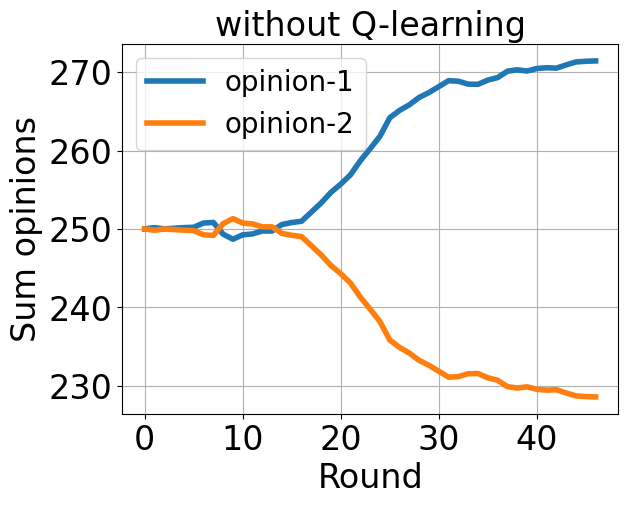

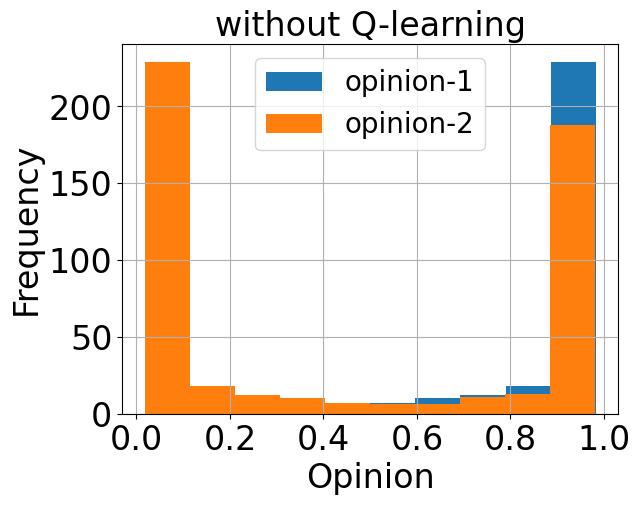

<Figure size 640x480 with 0 Axes>

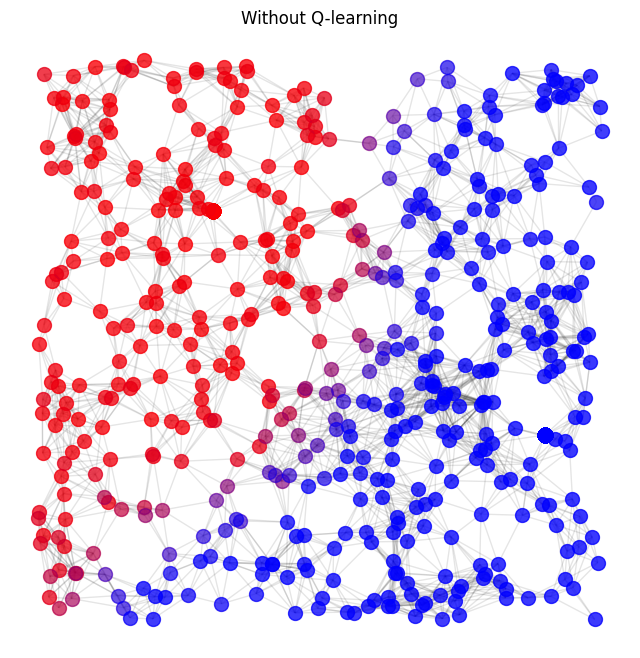

In [7]:
iterList = [0]

sim = {}
Params = {}
sim['savePath']             = "simRes"
sim['saveFileNameHead']     = "2024_18_02"
#Params['graphName']        = 'grid2d'
Params['graphName']        = 'rgg'
# Params['graphName']         = 'pa'
# Params['graphName']        = 'er'
# Params['genGraphFlg']       = False
Params['genGraphFlg']      = True
Params['eta']               = 0.
Params['xi']                = 1.
Params['tauMax']            = 10
Params['blfBatchSize']      = 15
Params['numPts']            = 100
Params['qLrnEn']       = False
# Params['qLrnEn']       = True
Params['saveSimresFlg'] = False


print(Params['graphName'])


if Params['graphName'] == 'rgg':
    # Params['numNodes']	= 1000
    # Params['rggRad']	= 0.07
    # Params['numRounds']	= Params['numPts']*Params['blfBatchSize']
    # Params['srcRNode']	= 700
    # Params['srcQNode']	= 800
    # Params['learnRate']	= 0.01
    # Params['gammaVal']	= 0.9
    # Params['tempVal']	= 0.1

    Params['numNodes']	= 500
    Params['rggRad']	= 0.1
    Params['numRounds']	= 700
    Params['srcRNode']	= 10
    Params['srcQNode']	= 490
    Params['learnRate']	= 0.01
    Params['gammaVal']	= 0.9
    Params['tempVal']	= 0.1

    # Params['numNodes']	    = 100
    # Params['rggRad']	    = 0.17
    # Params['numRounds']	    = 520
    # Params['srcRNode']	    = 90
    # Params['srcQNode']	    = 80
    # Params['learnRate']	    = 0.05
    # Params['gammaVal']	    = 0.9
    # Params['tempVal']	    = 0.1

elif Params['graphName'] == 'er':
#    Params['numNodes']	= 1000
#    Params['numRounds']	= 1020
#    Params['freezeRound']	= 1001
#    Params['srcNode']	= 990
#    Params['learnRate']	= 0.03
#    Params['gammaVal']	= 0.9
#    Params['gammaExtraVal']= 0.2
#    Params['blfBatchSize']	= 50.
#    Params['tempVal']	= 0.2

    Params['numNodes']	= 500
    Params['numRounds']	= 1020
    Params['srcQNode']	= 495
    Params['srcRNode']	= 12
    Params['learnRate']	= 0.1
    Params['gammaVal']	= 0.8
    Params['tempVal']	= 0.1

elif Params['graphName'] == 'pa':
#    Params['numNodes']	= 1000
#    Params['mVal']      = 3
#    Params['numRounds']	= Params['numPts']*Params['blfBatchSize']
#    #Params['srcQNode']	= 900 # low degree low eigvec centrality
#    #Params['srcQNode']	= 46 # best case - high degree and second highest eigvec centrality
#    Params['srcQNode']	= 128 # high degree - low eigvec centrality
#    Params['srcRNode']	= 5 # Hub
#    Params['learnRate']	= 0.2
#    Params['gammaVal']	= 0.8
#    Params['tempVal']	= 0.1

    Params['numNodes']	= 500
    Params['mVal']  = 3
    Params['numRounds']	= Params['numPts']*Params['blfBatchSize']
    Params['srcQNode']	= 400
    #Params['srcQNode']	= 495
    #Params['srcRNode']	= 12
    Params['srcRNode']	= 1
    Params['learnRate']	= 0.1
    Params['gammaVal']	= 0.8
    Params['tempVal']	= 0.1

   #For Test
  #  Params['numNodes']	= 100
  #  Params['mVal']	        = 3
  #  Params['numRounds']	= 120
  #  Params['srcQNode']	= 75
  #  Params['srcRNode']	= 85
  #  Params['learnRate']	= 0.05
  #  Params['gammaVal']	= 0.8
  #  Params['tempVal']	= 0.1


for indIter in iterList:
    print("Iteration " + str(indIter))
    print("================================================= List of parameters - BEGIN =================================================")
    for paramName in Params.keys():
        print(paramName+" = ",Params[paramName])
    print("------------------------------------------------- List of parameters - END -------------------------------------------------")

    sim['iterNum'] = indIter
    qopin_tb(sim, Params)


